Found 93 files belonging to 3 classes.
Using 75 files for training.
Using 18 files for validation.
Found 93 files belonging to 3 classes.
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 128, 128, 3)       0         
                                                                 
 random_rotation (RandomRota  (None, 128, 128, 3)      0         
 tion)                                                           
                                                                 
 random_translation (RandomT  (None, 128, 128, 3)      0         
 ranslation)                                                     
                                                                 
 random_zoom (RandomZoom)    (None, 128, 128, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 126, 126, 32

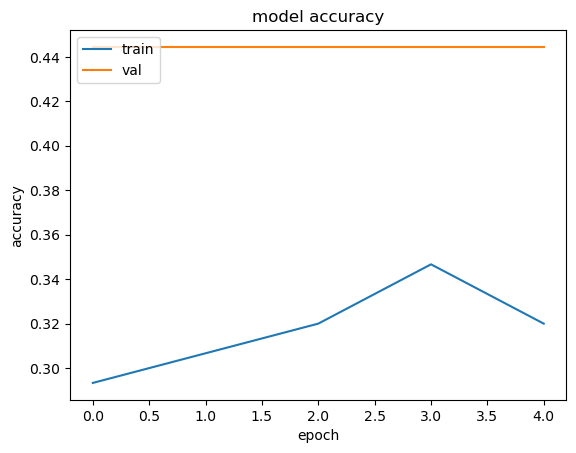

In [10]:


import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.models import Sequential

from keras.layers import Dense, Dropout, Flatten, Rescaling, Input
from keras.optimizers import RMSprop, Adam, SGD
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, Rescaling, BatchNormalization
from keras.layers import RandomFlip, RandomTranslation, RandomZoom, RandomRotation

from sklearn.metrics import classification_report

# import src.cfg as cfg
# import src.myModels as models_store
# import src.helpers as h

# print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


def getClassWeights(ds):
    labels = np.asarray(list(ds.unbatch().map(lambda x, y: y)))
    count_0 = np.sum(labels == 0)
    count_1 = np.sum(labels == 1)
    count_2 = np.sum(labels == 2)

    max_class = max(count_0, count_1, count_2)

    weight_0 = max_class/count_0
    weight_1 = max_class/count_1
    weight_2 = max_class/count_2
    class_wght = {0: weight_0, 1: weight_1, 2:  weight_2}
    print(f'Weights: {class_wght}')
    return class_wght


fit = True  # make fit false if you do not want to train the network again
train_dir = 'src/data/train'
test_dir = 'src/data/test'

img_height = 128
img_width = 128
img_channels = 3
num_classes = 3

batch_size = 12

epochs = 5
momentum = 0.5
learning_rate = 0.001

dropout = 0.2
units = 512

shape = (img_height, img_width, img_channels)

with tf.device('/gpu:0'):
    train_ds, val_ds = tf.keras.preprocessing.image_dataset_from_directory(
        train_dir,
        seed=123,
        validation_split=0.2,
        subset='both',
        image_size=(img_height, img_width),
        batch_size=batch_size,
        labels='inferred',
        shuffle=True)

    test_ds = tf.keras.preprocessing.image_dataset_from_directory(
        test_dir,
        seed=None,
        image_size=(img_height, img_width),
        batch_size=batch_size,
        labels='inferred',
        shuffle=True)

    class_names = train_ds.class_names

    # train_f, train_labels = h.split_ds(train_ds)
    # test_f, test_labels = h.split_ds(test_ds)

    # https://medium.com/@ali.oraji/keras-pre-trained-models-for-image-classification-b36c86f8de0d

    pred_model3 = tf.keras.applications.ResNet50V2(
        include_top=False, input_shape=shape, pooling='avg', classes=3, weights='imagenet')
    for layer in pred_model3.layers:
        layer.trainable = False

    # h.tuner(train_ds, overwrite=False)

    ############################
    ####   Define Model   ######
    ############################

    model = Sequential()
    model.add(Input(shape=shape))

    # preprocessing
    model.add(Rescaling(1.0/255))

    # augmentation
    random_Rotation = 0.06
    translation_factors = 0.1
    randomZoom = 0.07

    #model.add(RandomFlip("horizontal and vertical"))
    model.add(RandomRotation(random_Rotation))
    model.add(RandomTranslation(height_factor=translation_factors,
              width_factor=translation_factors))
    model.add(RandomZoom(randomZoom))

    # layers
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D(2, 2))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(2, 2))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(2, 2))

    model.add(Flatten())

    nodes = 256
    for i in range(12):
        model.add(Dense(nodes, activation='relu'))
        if i % 2 == 0:
            model.add(Dropout(0.4))

    # Output layer
    model.add(Dense(num_classes, activation='softmax'))

    ############################
    ####   Optimisers   ########
    ############################
    optimiser = [
        Adam(),
        SGD(learning_rate=learning_rate,  momentum=momentum),
        RMSprop()
    ]

    ############################
    ####   Compile   ###########
    ############################
    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer=optimiser[1],
                  metrics=['accuracy'])

    ############################
    #####   Model Summary   ####
    ############################
    model.summary()

    ############################
    #######   FIT    ###########
    ############################

    save_callback = tf.keras.callbacks.ModelCheckpoint(
        "pneumonia.keras", save_freq='epoch', save_best_only=True)

    if fit:
        history = model.fit(
            train_ds,
            class_weight=getClassWeights(train_ds),
            batch_size=batch_size,
            validation_data=val_ds,
            callbacks=[save_callback],
            epochs=epochs)
        plt.plot(history.history['accuracy'])
        plt.plot(history.history['val_accuracy'])
        plt.title('model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend(['train', 'val'], loc='upper left')
    else:
        model = tf.keras.models.load_model("pneumonia.keras")

    ############################
    #######   evaluate    ######
    ############################
    # if shuffle=True when creating the dataset, samples will be chosen randomly
    score = model.evaluate(test_ds, batch_size=batch_size)
    print('Test accuracy:', score[1])
